In [1]:
!pip install gym
!pip install pyglet==1.5.11

  Using cached pyglet-1.5.0-py2.py3-none-any.whl (1.0 MB)
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.11
    Uninstalling pyglet-1.5.11:
      Successfully uninstalled pyglet-1.5.11
  Using cached pyglet-1.5.11-py3-none-any.whl (1.1 MB)
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.18.0 requires pyglet<=1.5.0,>=1.4.0, but you have pyglet 1.5.11 which is incompatible.


In [2]:
import gym
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import pandas as pd

n_states = 40

In [3]:
# Quantize the states
def discretization(env, obs):
    n_states = 40
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled
    
def MountainCar_Q_Table(episodes = 10, initial_lr = 1.0):
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    obs = env.reset()
    # env.render()
    # Some initializations
    #
    n_states = 40
    initial_lr = 1.0
    min_lr = 0.00005
    gamma = 0.98
    max_stps = 300
    epsilon = 0.05
    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    
    q_table = np.zeros((n_states, n_states, env.action_space.n))
    step_trace = []
    rewards_trace = []
    for episode in range(episodes):
        obs = env.reset()
        rewards = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        steps = 0
        while True:
    #       env.render()
            pos, vel = discretization(env, obs)
            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
            else:
                a = np.argmax(q_table[pos][vel])
            obs, reward, terminate,_ = env.step(a)
            rewards += reward
#             rewards += abs(obs[0]+0.5)
            pos_, vel_ = discretization(env, obs)
            # Q function update
            q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
            steps += 1
            if terminate:
                rewards_trace.append(rewards)
                step_trace.append(steps)
                break
    return q_table, rewards_trace, step_trace

In [4]:
def design_matrix(X, J=20):
  kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
  sig = np.std(X)
  U = np.zeros((X.shape[0], J))
  for i in range(X.shape[0]):
    for j in range(J):
       U[i][j] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_[j])/sig)
  return U

def rbf(J, q_table):
    n_states = 40
    pos_discretization = np.linspace(-1.2, 0.6, n_states)
    vel_discretization = np.linspace(-0.07, 0.07, n_states)
        
    X = []
    for i in range(n_states):
        for j in range(n_states):
            X.append([pos_discretization[i], vel_discretization[j]])
    X = np.array(X)

    U = design_matrix(X, J)
    w = np.dot((np.linalg.inv(np.dot(U.T, U))), U.T) @ q_table.reshape(-1, 3)
    yh_rbf = U @ w
    yh_rbf = yh_rbf.reshape(n_states, n_states, 3)
    return yh_rbf

def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low)/pos_den)
    vel_scaled = int((obs[1] - vel_low)/vel_den)
    return pos_scaled, vel_scaled

def rbf_hill(yh_rbf, episodes=10):
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    obs = env.reset()
    # env.render()
    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    initial_lr = 1.0
    min_lr = 0.005
    gamma = 0.99
    epsilon = 0.05

    rewards_trace = []
    step_trace = []
    for episode in range(episodes):
        obs = env.reset()
        rewards = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        steps = 0
        while True:
    #         env.render()
            pos, vel = discretization(env, obs)
            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
            else:
                a = np.argmax(yh_rbf[pos][vel])
            obs, reward, terminate,_ = env.step(a)
            rewards += reward
#             total_reward += abs(obs[0]+0.5)
            steps += 1
            if terminate:
                rewards_trace.append(rewards)
                step_trace.append(steps)
                break
    return rewards_trace, step_trace

In [37]:
episodes=10
q_table, q_rewards_trace, q_step_trace = MountainCar_Q_Table(episodes, 10.1)
yh_rbf_20 = rbf(20, q_table)
yh_rbf_100 = rbf(100, q_table)
yh_rbf_500 = rbf(500, q_table)

rewards_trace_20, step_trace_20 = rbf_hill(yh_rbf_20, episodes)
rewards_trace_100, step_trace_100 = rbf_hill(yh_rbf_100, episodes)
rewards_trace_500, step_trace_500 = rbf_hill(yh_rbf_500, episodes)

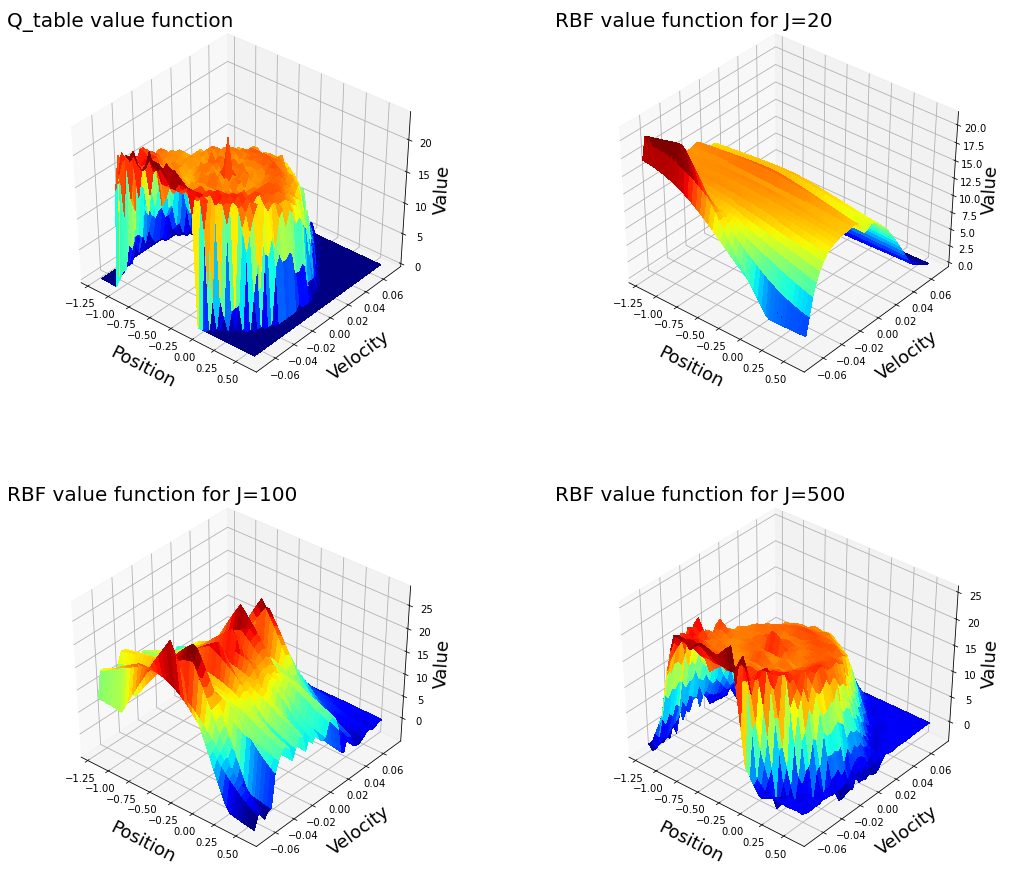

In [6]:
pos_discretization = np.linspace(-1.2, 0.6, n_states)
vel_discretization = np.linspace(-0.07, 0.07, n_states)
pos_grid, vel_grid = np.meshgrid(pos_discretization, vel_discretization)
Z_table = -np.max(q_table, 2)
Z_rbf_20 = -np.max(yh_rbf_20, 2)
Z_rbf_100 = -np.max(yh_rbf_100, 2)
Z_rbf_500 = -np.max(yh_rbf_500, 2)

fig = plt.figure(figsize=(18,16))

ax_0 = fig.add_subplot(221, projection='3d', elev=40, azim=-50)
ax_0.plot_surface(pos_grid, vel_grid, Z_table, cmap=cm.jet, linewidth=0, antialiased=False)
ax_0.set_title('Q_table value function', loc='left', pad=-19.5, fontsize=20)
ax_0.set_xlabel('Position', fontsize=18)
ax_0.set_ylabel('Velocity', fontsize=18)
ax_0.set_zlabel('Value', fontsize=18);
ax_0.xaxis.labelpad=15
ax_0.yaxis.labelpad=15
ax_0.zaxis.labelpad=4
ax_0.dist = 11

ax_1 = fig.add_subplot(222, projection='3d', elev=40, azim=-50)
ax_1.plot_surface(pos_grid, vel_grid, Z_rbf_20, cmap=cm.jet, linewidth=0, antialiased=False)
ax_1.set_title('RBF value function for J=20', loc='left', pad=-19.5, fontsize=20)
ax_1.set_xlabel('Position', fontsize=18)
ax_1.set_ylabel('Velocity', fontsize=18)
ax_1.set_zlabel('Value', fontsize=18);
ax_1.xaxis.labelpad=15
ax_1.yaxis.labelpad=15
ax_1.zaxis.labelpad=4
ax_1.dist = 11

ax_2 = fig.add_subplot(223, projection='3d', elev=40, azim=-50)
ax_2.plot_surface(pos_grid, vel_grid, Z_rbf_100, cmap=cm.jet, linewidth=0, antialiased=False)
ax_2.set_title('RBF value function for J=100', loc='left', pad=-19.5, fontsize=20)
ax_2.set_xlabel('Position', fontsize=18)
ax_2.set_ylabel('Velocity', fontsize=18)
ax_2.set_zlabel('Value', fontsize=18);
ax_2.xaxis.labelpad=15
ax_2.yaxis.labelpad=15
ax_2.zaxis.labelpad=4
ax_2.dist = 11

ax_3 = fig.add_subplot(224, projection='3d', elev=40, azim=-50)
ax_3.plot_surface(pos_grid, vel_grid, Z_rbf_500, cmap=cm.jet, linewidth=0, antialiased=False)
ax_3.set_title('RBF value function for J=500', loc='left', pad=-19.5, fontsize=20)
ax_3.set_xlabel('Position', fontsize=18)
ax_3.set_ylabel('Velocity', fontsize=18)
ax_3.set_zlabel('Value', fontsize=18);
ax_3.xaxis.labelpad=15
ax_3.yaxis.labelpad=15
ax_3.zaxis.labelpad=4
ax_3.dist = 11
plt.show()

[369, 778, 606, 891, 474, 479, 390, 481, 1037, 615]
[3710, 1224, 6082, 1639, 4774, 2985, 5877, 1653, 1094, 12201]
[1159, 1106, 1333, 1016, 1317, 507, 807, 728, 552, 947]


Text(0.5, 1.0, 'Sum of Steps over Episode')

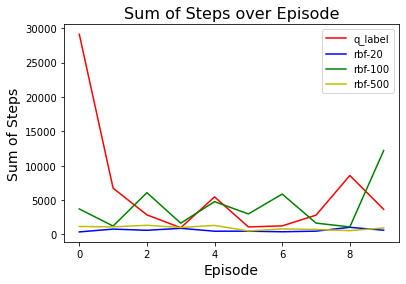

In [38]:
print(step_trace_20)
print(step_trace_100)
print(step_trace_500)

plt.plot(q_step_trace, c='r', label="q_label")
plt.plot(step_trace_20, c='b', label="rbf-20")
plt.plot(step_trace_100, c='g', label="rbf-100")
plt.plot(step_trace_500, c='y', label="rbf-500")
plt.legend()
plt.xlabel("Episode", size=14)
plt.ylabel("Sum of Steps", size=14)
plt.title("Sum of Steps over Episode", size=16)

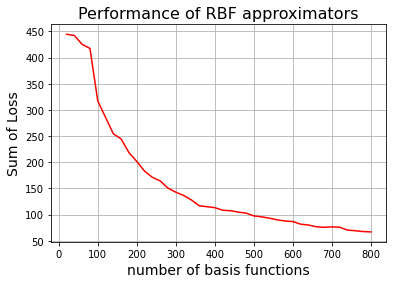

In [8]:
norm_list = []
for i in np.linspace(20, 800, 40, dtype=int):
    yh_rbf = rbf(i, q_table)
    norm_list.append(np.linalg.norm(q_table-yh_rbf))
    
plt.xlabel("number of basis functions", size=14)
plt.ylabel("Sum of Loss", size=14)
plt.grid()
plt.title("Performance of RBF approximators", size=16)
plt.plot(np.linspace(20, 800, 40, dtype=int), norm_list, c='r')

In [9]:
def MountainCar_Q_learning(J = 20, epsilon = 0.1, episodes = 100, initial_lr = 0.01):
    env = gym.make('MountainCar-v0')
    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    gamma = 0.99
    min_lr = 0.005
    actions = range(env.action_space.n)
    low = env.observation_space.low
    high = env.observation_space.high

    dataset = []
    for i in range(n_states):
        for j in range(n_states):
            dataset.append([pos_discretization[i], vel_discretization[j]])
    observation_examples = np.array(dataset)
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    rbf_space = [
            ("rbf_q-learning", RBFSampler(gamma=gamma, n_components=J)),
            ]
    design_matrix = FeatureUnion(rbf_space)
    design_matrix.fit_transform(scaler.transform(observation_examples))
    weights = np.random.random((len(actions), J*len(rbf_space))) * 0.01
    rewards_trace = []
    step_trace = []
    for episode in range(episodes):
        obs = env.reset()
        steps = 0
        rewards = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        while True:
            if np.random.uniform(low=0, high=1) < epsilon:
                action = np.random.choice(env.action_space.n)
            else:
                X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
                q = [np.dot(X, weights[act]) for act in actions]
                action = np.argmax(q)

            prev_obs = obs
            obs, reward, terminate,_ = env.step(action)
#             rewards += abs(obs[0]+0.5)
            rewards += reward

            # update the model by online q-learning
            X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
            G = reward + gamma*max([np.dot(X, weights[a]) for a in actions])
            X = design_matrix.transform(scaler.transform([prev_obs])).reshape(-1)
            gradient = np.dot(X, (G - np.dot(X, weights[action])))
            weights[action] += alpha * gradient
            steps += 1
            if terminate:
                rewards_trace.append(rewards)
                step_trace.append(steps)
                break

    # plot("Q-Learning RBF function", weights, rewards_trace, step_trace)
    rbf_q_table = design_matrix.transform(scaler.transform(dataset))@ weights.T
    rbf_q_table = rbf_q_table.reshape(n_states, n_states, len(actions))
    return rbf_q_table, rewards_trace, step_trace

In [10]:
def MountainCar_SARSA(J = 20, epsilon = 0.1, episodes = 100, initial_lr = 0.01, greedy=0.1):
    env = gym.make('MountainCar-v0')
    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    gamma = 0.99
    min_lr = 0.005
    actions = range(env.action_space.n)
    low = env.observation_space.low
    high = env.observation_space.high

    dataset = []
    for i in range(n_states):
        for j in range(n_states):
            dataset.append([pos_discretization[i], vel_discretization[j]])
    observation_examples = np.array(dataset)
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    rbf_space = [
            ("rbf_SARSA", RBFSampler(gamma=gamma, n_components=J)),
            ]
    design_matrix = FeatureUnion(rbf_space)
    design_matrix.fit_transform(scaler.transform(observation_examples))
    weights = np.random.random((len(actions), J*len(rbf_space))) * 0.01
    rewards_trace = []
    step_trace = []
    for episode in range(episodes):
        obs = env.reset()
        steps = 0
        rewards = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        while True:
            if np.random.uniform(low=0, high=1) < epsilon:
                action = np.random.choice(env.action_space.n)
            else:
                X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
                q = [np.dot(X, weights[act]) for act in actions]
                action = np.argmax(q)

            prev_obs = obs
            obs, reward, terminate,_ = env.step(action)
            rewards += reward
#             rewards += abs(obs[0]+0.5)

            X = design_matrix.transform(scaler.transform([obs])).reshape(-1)
            # update the model by online SARSA
            if np.random.uniform(0,1) < greedy:
                next_action = np.random.choice(env.action_space.n)
            else:
                next_action = np.argmax([np.dot(X, weights[a]) for a in actions])
            G = reward + gamma*np.dot(X, weights[next_action])
            X = design_matrix.transform(scaler.transform([prev_obs])).reshape(-1)
            gradient = np.dot(X, (G - np.dot(X, weights[action])))
            weights[action] += alpha * gradient
            steps += 1
            if terminate:
                rewards_trace.append(rewards)
                step_trace.append(steps)
                break

    # plot("SARSA RBF function", weights, rewards_trace, step_trace)
    rbf_s_table = design_matrix.transform(scaler.transform(dataset))@ weights.T
    rbf_s_table = rbf_s_table.reshape(n_states, n_states, len(actions))
    return rbf_s_table, rewards_trace, step_trace

In [11]:
q_table, q_rewards_trace, q_step_trace = MountainCar_Q_Table(200, initial_lr = 0.1)
print("Q_Table")
rbf_20_q_table, rbf_20_q_rewards_trace, rbf_20_q_step_trace = MountainCar_Q_learning(J=20, episodes = 200)
print("MountainCar_Q_learning")
rbf_20_s_table, rbf_20_s_rewards_trace, rbf_20_s_step_trace = MountainCar_SARSA(J=20, episodes = 200, greedy=0.9)
print("MountainCar_SARSA")

Q_Table
MountainCar_Q_learning
MountainCar_SARSA


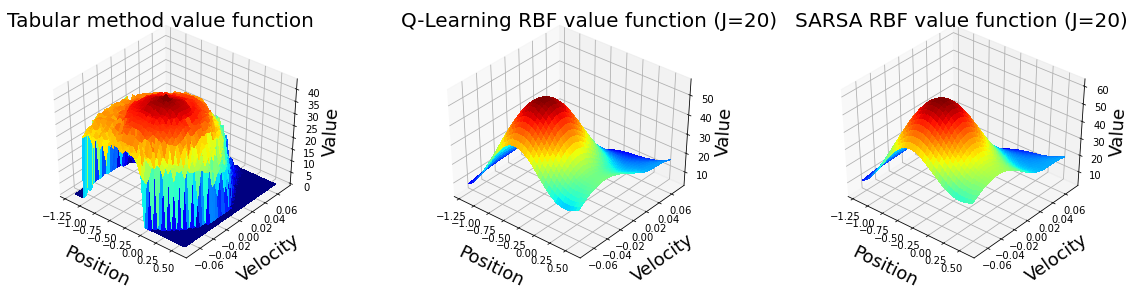

In [12]:
fig = plt.figure(figsize=(20,5))

ax_1 = fig.add_subplot(131, projection='3d', elev=40, azim=-50)
Z_q_table = -np.max(q_table, 2)
ax_1.plot_surface(pos_grid, vel_grid, Z_q_table, cmap=cm.jet, linewidth=0, antialiased=False)
ax_1.set_title('Tabular method value function', loc='left', pad=-19.5, fontsize=20)
ax_1.set_xlabel('Position', fontsize=18)
ax_1.set_ylabel('Velocity', fontsize=18)
ax_1.set_zlabel('Value', fontsize=18);
ax_1.xaxis.labelpad=15
ax_1.yaxis.labelpad=15
ax_1.zaxis.labelpad=4
ax_1.dist = 11

ax_2 = fig.add_subplot(132, projection='3d', elev=40, azim=-50)
Z_rbf_q_20 = -np.max(rbf_20_q_table, 2)
ax_2.plot_surface(pos_grid, vel_grid, Z_rbf_q_20, cmap=cm.jet, linewidth=0, antialiased=False)
ax_2.set_title('Q-Learning RBF value function (J=20)', loc='left', pad=-19.5, fontsize=20)
ax_2.set_xlabel('Position', fontsize=18)
ax_2.set_ylabel('Velocity', fontsize=18)
ax_2.set_zlabel('Value', fontsize=18);
ax_2.xaxis.labelpad=15
ax_2.yaxis.labelpad=15
ax_2.zaxis.labelpad=4
ax_2.dist = 11

ax_3 = fig.add_subplot(133, projection='3d', elev=40, azim=-50)
Z_rbf_s_20 = -np.max(rbf_20_s_table, 2)
ax_3.plot_surface(pos_grid, vel_grid, Z_rbf_s_20, cmap=cm.jet, linewidth=0, antialiased=False)
ax_3.set_title('SARSA RBF value function (J=20)', loc='left', pad=-19.5, fontsize=20)
ax_3.set_xlabel('Position', fontsize=18)
ax_3.set_ylabel('Velocity', fontsize=18)
ax_3.set_zlabel('Value', fontsize=18);
ax_3.xaxis.labelpad=15
ax_3.yaxis.labelpad=15
ax_3.zaxis.labelpad=4
ax_3.dist = 11

In [27]:
import pandas as pd
smoothing_window = 5
q_rewards_trace_mean = pd.Series(q_rewards_trace).rolling(smoothing_window).mean()
q_step_trace_mean = pd.Series(q_step_trace).rolling(smoothing_window).mean()

# smoothing_window = 10
rbf_20_q_rewards_trace_mean = pd.Series(rbf_20_q_rewards_trace).rolling(smoothing_window).mean()
rbf_20_s_rewards_trace_mean = pd.Series(rbf_20_s_rewards_trace).rolling(smoothing_window).mean()

rbf_20_q_step_trace_mean = pd.Series(rbf_20_q_step_trace).rolling(smoothing_window).mean()
rbf_20_s_step_trace_mean = pd.Series(rbf_20_s_step_trace).rolling(smoothing_window).mean()

Text(0.5, 1.0, 'Episode Steps Count')

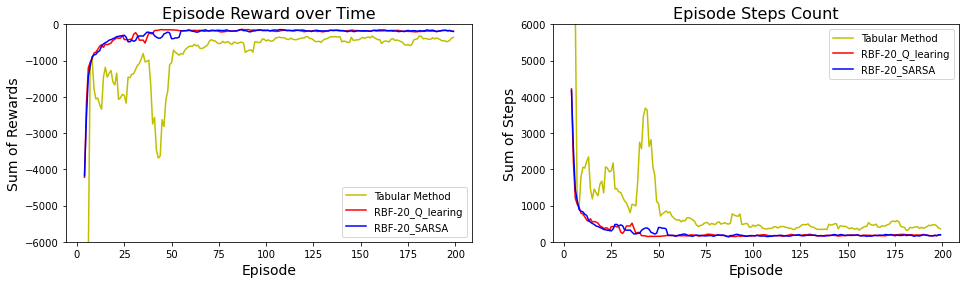

In [40]:
fig = plt.figure(figsize=(16,4))
ax_0 = fig.add_subplot(121)
ax_0.plot(q_rewards_trace_mean, c='y', label="Tabular Method")
ax_0.plot(rbf_20_q_rewards_trace_mean, c='r', label="RBF-20_Q_learing")
# ax_0.plot(rbf_100_q_rewards_trace, c='g', label="rbf-100_q_learing")
ax_0.plot(rbf_20_s_rewards_trace_mean, c='b', label="RBF-20_SARSA")
# ax_0.plot(rbf_100_s_rewards_trace, c='m', label="rbf-100_sarsa")
ax_0.legend()
ax_0.set_xlabel("Episode", size=14)
ax_0.set_ylabel("Sum of Rewards", size=14)
ax_0.set_title("Episode Reward over Time", size=16)
ax_0.set_ylim((-6000, 0))
ax_1 = fig.add_subplot(122)
ax_1.plot(q_step_trace_mean, c='y', label="Tabular Method")
ax_1.plot(rbf_20_q_step_trace_mean, c='r', label="RBF-20_Q_learing")
# ax_1.plot(rbf_100_q_step_trace, c='g', label="rbf-100_q_learing")
ax_1.plot(rbf_20_s_step_trace_mean, c='b', label="RBF-20_SARSA")
# ax_1.plot(rbf_100_s_step_trace, c='m', label="rbf-100_sarsa")
ax_1.legend()
ax_1.set_xlabel("Episode", size=14)
ax_1.set_ylabel("Sum of Steps", size=14)
ax_1.set_ylim((0, 6000))
ax_1.set_title("Episode Steps Count", size=16)

Text(0.5, 1.0, 'Episode Steps Count (Compare Q-learning and Sarsa)')

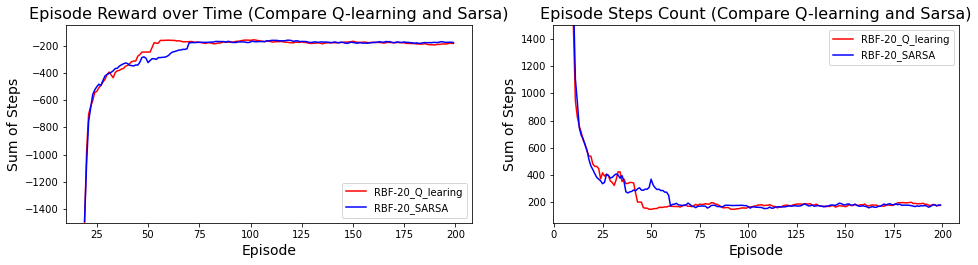

In [16]:
fig = plt.figure(figsize=(16,8))
ax_2 = fig.add_subplot(223)
ax_2.plot(rbf_20_q_rewards_trace_mean, c='r', label="RBF-20_Q_learing")
ax_2.plot(rbf_20_s_rewards_trace_mean, c='b', label="RBF-20_SARSA")
ax_2.legend()
ax_2.set_xlabel("Episode", size=14)
ax_2.set_ylabel("Sum of Steps", size=14)
ax_2.set_ylim((-1500, -50))
ax_2.set_title("Episode Reward over Time (Compare Q-learning and Sarsa)", size=16)
ax_3 = fig.add_subplot(224)
ax_3.plot(rbf_20_q_step_trace_mean, c='r', label="RBF-20_Q_learing")
ax_3.plot(rbf_20_s_step_trace_mean, c='b', label="RBF-20_SARSA")
ax_3.legend()
ax_3.set_xlabel("Episode", size=14)
ax_3.set_ylabel("Sum of Steps", size=14)
ax_3.set_ylim((50, 1500))
ax_3.set_title("Episode Steps Count (Compare Q-learning and Sarsa)", size=16)